# Import required Library 

In [161]:
from pandas_datareader import data
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num
#from matplotlib.finance import candlestick_ohlc as candlestick
from mplfinance.original_flavor import candlestick_ohlc as candlestick # pls install matplotlib for candle stick plot 
import datetime
import requests

# Market Data

## Download Market Data

In [162]:
#ticker = '5099.kl'
# Last 3 years closing prices starting from Jan 2, 2018.
 
#now = datetime.datetime.now()
#startyear = 2018
#startmonth = 1 
#startday = 1
#start = datetime.datetime(startyear, startmonth, startday)
#sec_id = pdr.get_data_yahoo(ticker, start, now)
#sec_id.tail()


## Download Crypto history data

In [163]:
ticker = 'ethbtc'
base = 'https://api.huobi.pro'
url = '/market/history/kline?period=4hour&size=2000&symbol=ethusdt'
final_url = base + url

reqs = requests.get(final_url)

df = pd.DataFrame(reqs.json()['data'])
df["Date"] = pd.to_datetime(df["id"], unit='s', origin='unix')
df["Date"] = df["Date"].dt.strftime("%m/%d/%Y %H:%M:%S")
df.drop('id',axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace = True)
df.rename(columns={'high':'High','low':'Low','open':'Open','close':'Close','vol':'Volume'},inplace=True)
df['Adj Close']= df['Close']
#df = df[['High','Low','Open','Close','Volume','Adj Close']]
df.sort_index(inplace = True)

sec_id= df


# Create technical Indicator

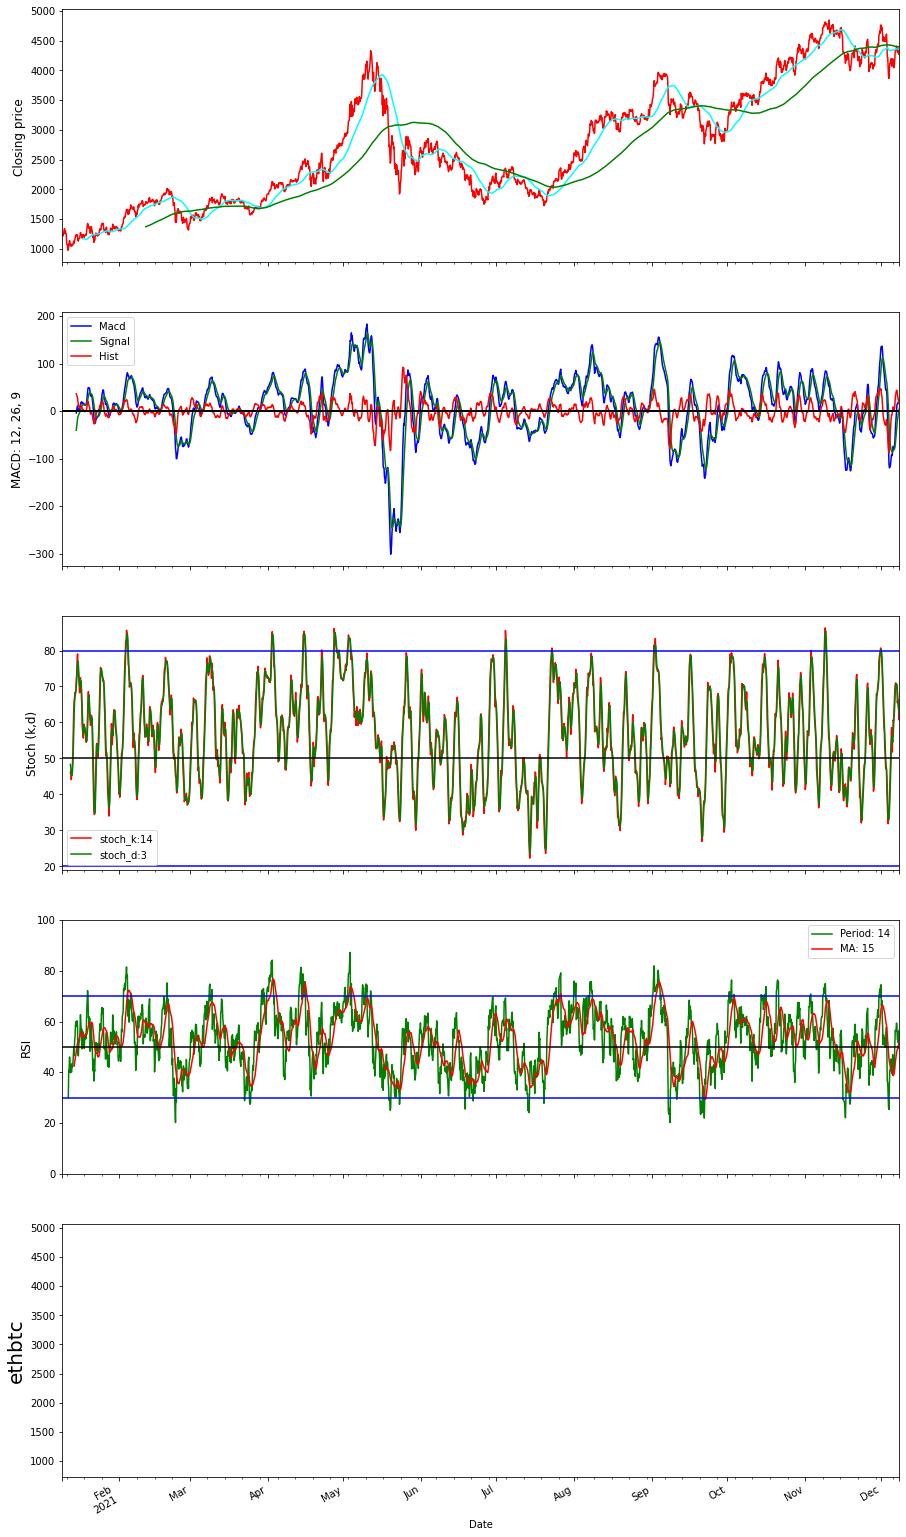

In [164]:

#ticker = 'OPK'

# Download sample data
#sec_id = data.get_data_yahoo(ticker, '2014-06-01')

# Data for matplotlib finance plot
sec_id_ochl = np.array(pd.DataFrame({'0':date2num(sec_id.index.to_pydatetime()),
                                '1':sec_id.Open,
                                '2':sec_id.Close,
                                '3':sec_id.High,
                                '4':sec_id.Low}))

# Technical Analysis
SMA_FAST = 50
SMA_SLOW = 200
RSI_PERIOD = 14
RSI_AVG_PERIOD = 15
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9
STOCH_K = 14
STOCH_D = 3
SIGNAL_TOL = 3
Y_AXIS_SIZE = 12

analysis = pd.DataFrame(index = sec_id.index)

#analysis['sma_f'] = pd.rolling_mean(sec_id.Close, SMA_FAST)
analysis['sma_f'] = sec_id.Close.rolling(SMA_FAST).mean()

#analysis['sma_s'] = pd.rolling_mean(sec_id.Close, SMA_SLOW)
analysis['sma_s'] = sec_id.Close.rolling(SMA_SLOW).mean()
#analysis['rsi'] = ta.RSI(sec_id.Close.as_matrix(), RSI_PERIOD)
analysis['rsi'] = ta.RSI(sec_id.Close.to_numpy(), RSI_PERIOD)
#analysis['sma_r'] = pd.rolling_mean(analysis.rsi, RSI_AVG_PERIOD) # check shift
analysis['sma_r'] = analysis.rsi.rolling(RSI_AVG_PERIOD).mean() # check shift

#analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(sec_id.Close.as_matrix(), fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(sec_id.Close.to_numpy(), fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
#analysis['stoch_k'], analysis['stoch_d'] = ta.STOCH(sec_id.High.as_matrix(), sec_id.Low.as_matrix(), sec_id.Close.as_matrix(), slowk_period=STOCH_K, slowd_period=STOCH_D)
analysis['stoch_k'], analysis['stoch_d'] = ta.STOCH(sec_id.High.to_numpy(), sec_id.Low.to_numpy(), sec_id.Close.to_numpy(), slowk_period=STOCH_K, slowd_period=STOCH_D)

analysis['sma'] = np.where(analysis.sma_f > analysis.sma_s, 1, 0)
analysis['macd_test'] = np.where((analysis.macd > analysis.macdSignal), 1, 0)
analysis['stoch_k_test'] = np.where((analysis.stoch_k < 50) & (analysis.stoch_k > analysis.stoch_k.shift(1)), 1, 0)
analysis['rsi_test'] = np.where((analysis.rsi < 50) & (analysis.rsi > analysis.rsi.shift(1)), 1, 0)
analysis[['Open','Close','High','Low']]= sec_id[['Open','Close','High','Low']]
# Make Shift for easy know cross line from nagetive 
analysis['macdHist_shift'] = analysis['macdHist'].shift(1)

# Prepare plot
fig, (ax5, ax3, ax4, ax2,ax1) = plt.subplots(5, 1, sharex=True)
ax1.set_ylabel(ticker, size=20)

#size plot
fig.set_size_inches(15,30)

# Plot candles
candlestick(ax1, sec_id_ochl, width=0.5, colorup='#53c156', colordown='#ff1717', alpha=1)

# Draw Moving Averages
analysis.sma_f.plot(ax=ax1, c='r')
analysis.sma_s.plot(ax=ax1, c='g')

#RSI
ax2.set_ylabel('RSI', size=Y_AXIS_SIZE)
analysis.rsi.plot(ax = ax2, c='g', label = 'Period: ' + str(RSI_PERIOD))
analysis.sma_r.plot(ax = ax2, c='r', label = 'MA: ' + str(RSI_AVG_PERIOD))
ax2.axhline(y=30, c='b')
ax2.axhline(y=50, c='black')
ax2.axhline(y=70, c='b')
ax2.set_ylim([0,100])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)

# Draw MACD computed with Talib
ax3.set_ylabel('MACD: '+ str(MACD_FAST) + ', ' + str(MACD_SLOW) + ', ' + str(MACD_SIGNAL), size=Y_AXIS_SIZE)
analysis.macd.plot(ax=ax3, color='b', label='Macd')
analysis.macdSignal.plot(ax=ax3, color='g', label='Signal')
analysis.macdHist.plot(ax=ax3, color='r', label='Hist')
ax3.axhline(0, lw=2, color='0')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels)

# Stochastic plot
ax4.set_ylabel('Stoch (k,d)', size=Y_AXIS_SIZE)
analysis.stoch_k.plot(ax=ax4, label='stoch_k:'+ str(STOCH_K), color='r')
analysis.stoch_d.plot(ax=ax4, label='stoch_d:'+ str(STOCH_D), color='g')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels)
ax4.axhline(y=20, c='b')
ax4.axhline(y=50, c='black')
ax4.axhline(y=80, c='b')


#Closing price 
ax5.set_ylabel('Closing price ', size=Y_AXIS_SIZE)
analysis['Close'].plot(ax=ax5, label='stoch_k:'+ str(STOCH_K), color='r')
analysis.sma_f.plot(ax=ax5, c='cyan')
analysis.sma_s.plot(ax=ax5, c='g')
#handles, labels = ax4.get_legend_handles_labels()
#ax5.legend(handles, labels)
#ax4.axhline(y=20, c='b')
#ax4.axhline(y=50, c='black')
#ax4.axhline(y=80, c='b')
plt.show()


# Buy and Sell position

## Buy Position

In [165]:
buysell_record = pd.read_csv('Buysell record.csv')

buysell_record

,Index,Buy_Price,Target,Stop Loss,Status,Gain,Invest(usdt)
0,1,0,0,0,close,0,4000


In [166]:
# call module ' load market price/data' 
# for loop, read data line by line 
for x in range (len(analysis)):
    #print (buysell_record['Status'].iloc[-1])
    if buysell_record['Status'].iloc[-1] == 'close':
        #print('Status is CLOSE')
        # call buy module 
        #if (analysis['macdHist_shift'][x] < 0  ) and (analysis['macdHist'][x] >  -5) and (analysis['macd'][x] < -0.2):
        hist_diff = analysis['macdHist'][x-1] -analysis['macdHist'][x]
        #if (analysis['macdHist_shift'][x] < analysis['macdHist'][x]) and (analysis['macd'][x] < -0.2):
        if (analysis['macdHist_shift'][x] < analysis['macdHist'][x]) and (hist_diff <= 10 ):
            #print ('I am in buy section')
            buy_price = analysis['Close'][x]
            Target_gain = 1.10
            StopLoss_rate = 1 - 0.10
            TargetSellPrice = buy_price * Target_gain
            Stoploss_= buy_price * StopLoss_rate
            #print('Target_gain',Target_gain)
            #print('StopLoss_rate',StopLoss_rate)

            #print('Buy price === ', buy_price)
            #print('TargetSellPrice   ',TargetSellPrice)
            #print('Stoploss_ = ',Stoploss_)
            a_series = pd.Series([analysis.index[x],buy_price,TargetSellPrice,Stoploss_,'open',0,np.nan],index = buysell_record.columns)
            buysell_record= buysell_record.append(a_series,ignore_index=True)
                  
                
    elif buysell_record['Status'].iloc[-1] == 'open':
        #print('I am in Sell section ****')
        # call sell module 
        if (analysis['Close'][x] >= buysell_record['Target'].iloc[-1]) :
        #if (analysis['macdHist_shift'][x] > analysis['macdHist'][x]):
            buysell_record['Status'].iloc[-1]= 'close'

            buysell_record['Gain'].iloc[-1] = analysis['Close'][x]- buysell_record['Buy_Price'].iloc[-1]
        #"""    
        elif (analysis['Close'][x] < buysell_record['Stop Loss'].iloc[-1]):
            buysell_record['Status'].iloc[-1]= 'close'

            buysell_record['Gain'].iloc[-1] = analysis['Close'][x]- buysell_record['Buy_Price'].iloc[-1]
        #"""



/Users/khawchanyong/opt/anaconda3/envs/myproject-env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [167]:
buysell_record['Gain(%)']=(buysell_record['Gain']/ buysell_record['Buy_Price']) *100
for i in range(len(buysell_record)-1):
    buysell_record['Invest(usdt)'][i+1] = buysell_record['Invest(usdt)'][i] + ( buysell_record['Invest(usdt)'][i] * (buysell_record['Gain(%)'][i+1] /100))
buysell_record

<ipython-input-167-b7a08c7c2e33>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buysell_record['Invest(usdt)'][i+1] = buysell_record['Invest(usdt)'][i] + ( buysell_record['Invest(usdt)'][i] * (buysell_record['Gain(%)'][i+1] /100))


,Index,Buy_Price,Target,Stop Loss,Status,Gain,Invest(usdt),Gain(%)
0,1,0.00,0.000,0.000,close,0.00,4000.000000,NaN
1,2021-01-16 08:00:00,1218.58,1340.438,1096.722,close,155.79,4511.382100,12.784553
2,2021-01-19 08:00:00,1428.63,1571.493,1285.767,close,-163.31,3995.675577,-11.431231
3,2021-01-20 16:00:00,1345.50,1480.050,1210.950,close,-156.81,3530.003420,-11.654404
4,2021-01-22 04:00:00,1143.74,1258.114,1029.366,close,123.78,3912.034147,10.822390
...,...,...,...,...,...,...,...,...
59,2021-10-28 20:00:00,4285.15,4713.665,3856.635,close,435.91,10689.956370,10.172573
60,2021-11-08 04:00:00,4723.44,5195.784,4251.096,close,-515.09,9524.219190,-10.904976
61,2021-11-17 04:00:00,4183.37,4601.707,3765.033,close,430.31,10503.899868,10.286205
62,2021-11-30 16:00:00,4662.52,5128.772,4196.268,close,-603.45,9144.425083,-12.942572


In [168]:
buysell_record['Gain'].sum()

2059.000000000002

In [169]:
buysell_record['Gain(%)'].sum()

124.18338820690632

In [170]:
buysell_record['Invest(usdt)'].iloc[-1]

9144.425083198386

In [171]:
(buysell_record['Invest(usdt)'].iloc[-1] - buysell_record['Invest(usdt)'][0] ) * 4

20577.700332793545

In [172]:

cond_buy = [
    (analysis['macdHist_shift'] <  0) & (analysis['macdHist'] >  0) & (analysis['macd'] < -0.02),
    ]
values_buy = [analysis['Close']]
values_BuySignal = ['Buy']

analysis['Buy_Price'] = np.select(cond_buy, values_buy,np.nan)
analysis['BuySell_Signal'] = np.select(cond_buy, values_BuySignal,' ')


## Sell Position

In [173]:
TargetSell = np.nan
StopLoss = np.nan
analysis['Sell_Price'] = np.nan
for i in analysis.index:
    if analysis['Buy_Price'][i] > 0:
        BuyPrice = analysis['Buy_Price'][i]
        print('Buy Price  ++ ',BuyPrice)
        TargetSell = BuyPrice * 1.03
        StopLoss = BuyPrice * -1.04
        print('Target profit 2%', TargetSell)
    print('Close Price == ', analysis['Close'][i])
    if (analysis['Close'][i] > TargetSell) & (TargetSell != np.nan):
        SellPrice = analysis['Close'][i]
        print('Sell Price *** ', SellPrice)
        TargetSell = np.nan
        analysis['Sell_Price'][i] = analysis['Close'][i]
        analysis['BuySell_Signal'][i] = 'Sell'
    elif (analysis['Close'][i] < StopLoss) & (TargetSell != np.nan):
        SellPrice = analysis['Close'][i]
        analysis['BuySell_Signal'][i] = 'Sell'
        print('Sell Price losssssss *** ', SellPrice)
        TargetSell = np.nan
        #analysis['Buy_signal'][i] = analysis['Close'][i]
        

Close Price ==  1220.41
Close Price ==  1219.24
Close Price ==  1229.11
Close Price ==  1275.72
Close Price ==  1311.27
Close Price ==  1343.9
Close Price ==  1259.47
Close Price ==  1303.13
Close Price ==  1263.61
Close Price ==  1254.81
Close Price ==  1103.63
Close Price ==  1071.71
Close Price ==  1068.37
Close Price ==  976.96
Close Price ==  984.3
Close Price ==  1086.48
Close Price ==  1088.7
Close Price ==  1139.05
Close Price ==  1098.85
Close Price ==  1053.35
Close Price ==  1082.54
Close Price ==  1050.39
Close Price ==  1046.5
Close Price ==  1076.46
Close Price ==  1061.5
Close Price ==  1071.17
Close Price ==  1102.04
Close Price ==  1129.74
Close Price ==  1096.2
Close Price ==  1147.82
Close Price ==  1166.29
Close Price ==  1212.88
Close Price ==  1231.3
Close Price ==  1232.16
Close Price ==  1219.07
Close Price ==  1240.0
Close Price ==  1226.14
Close Price ==  1142.16
Close Price ==  1133.54
Close Price ==  1168.0
Close Price ==  1179.12
Close Price ==  1182.6
Clos

<ipython-input-173-da1f0baf8f1b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['Sell_Price'][i] = analysis['Close'][i]
<ipython-input-173-da1f0baf8f1b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['BuySell_Signal'][i] = 'Sell'


 4026.23
Close Price ==  3909.17
Close Price ==  3901.95
Close Price ==  3875.12
Close Price ==  3751.21
Close Price ==  3646.07
Close Price ==  3827.2
Close Price ==  3866.6
Close Price ==  3790.3
Close Price ==  3632.63
Close Price ==  3419.35
Close Price ==  3581.06
Close Price ==  3240.0
Close Price ==  3520.44
Close Price ==  3516.58
Close Price ==  3285.75
Close Price ==  3378.97
Close Price ==  3282.42
Close Price ==  3384.41
Close Price ==  3510.02
Buy Price  ++  3533.17
Target profit 2% 3639.1651
Close Price ==  3533.17
Close Price ==  3346.35
Buy Price  ++  3404.04
Target profit 2% 3506.1612
Close Price ==  3404.04
Close Price ==  3374.77
Close Price ==  3097.06
Close Price ==  2985.17
Close Price ==  2722.21
Close Price ==  2740.0
Close Price ==  2599.88
Close Price ==  2443.4
Close Price ==  2472.55
Close Price ==  2712.01
Close Price ==  2754.6
Close Price ==  2903.75
Buy Price  ++  2783.57
Target profit 2% 2867.0771000000004
Close Price ==  2783.57
Close Price ==  2768.49

In [174]:
#analysis ['BuySell_signal'] = np.where(((analysis['macdHist_shift'] <  0) & (analysis['macdHist'] >  0)), 'Buy',(np.where(((analysis['macdHist_shift'] >  0) & (analysis['macdHist'] <  0)),'Sell',np.nan)))

In [175]:
#df_buy = analysis[(analysis['BuySell_signal'] == 'Buy') | (analysis['BuySell_signal'] == 'Sell')]
#df_buy['BuySell_signal'][0]== "Buy"
#
#df_buy['BuySell_signal'][0]== "Buy"

# Calculate Profit

In [176]:
df_buysell = analysis[(analysis['BuySell_signal'] == 'Buy') | (analysis['BuySell_signal'] == 'Sell')]
if df_buysell['BuySell_signal'][0]== "Sell" :
    df_buysell.drop(df_buysell.index[0] ,axis= 0 , inplace = True)
df_buysell_pivot = df_buysell[['Close','BuySell_signal']].reset_index()

KeyError: 'BuySell_signal'

In [ ]:
df_buysell_pivot['Profit']= np.nan
for x in range(0,len(df_buysell_pivot),2):
    df_buysell_pivot['Profit'][x+1] = df_buysell_pivot['Close'][x+1] - df_buysell_pivot['Close'][x] 

<ipython-input-98-fe2734e7bdb3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buysell_pivot['Profit'][x+1] = df_buysell_pivot['Close'][x+1] - df_buysell_pivot['Close'][x]


In [ ]:
df_buysell_pivot['Profit'].sum()

-0.1100001335144043

In [ ]:
df_buysell_pivot

,Date,Close,BuySell_signal,Profit
0,2021-03-22,2.75,Buy,NaN
1,2021-04-19,2.73,Sell,-0.02
2,2021-05-24,2.08,Buy,NaN
3,2021-07-12,2.20,Sell,0.12
4,2021-07-27,2.27,Buy,NaN
5,2021-07-28,2.12,Sell,-0.15
6,2021-09-06,2.14,Buy,NaN
7,2021-09-30,2.06,Sell,-0.08
8,2021-10-20,2.07,Buy,NaN
9,2021-11-11,2.09,Sell,0.02
